# Searching for initial parameters in cell colony spatial-temporal pattern generation
### Nicolás Araya, Martín Gutiérrez, Guillermo Iglesias

install pytorch lightning library, weights and biases and torchmetrics

In [16]:
%%capture
!pip install -qqq wandb pytorch-lightning torchmetrics

download dataset

In [17]:
!wget https://www.dropbox.com/s/z7m4ztpvkwp1w4u/gro_dataset.zip
!unzip gro_dataset.zip

--2023-02-03 06:42:02--  https://www.dropbox.com/s/z7m4ztpvkwp1w4u/gro_dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/z7m4ztpvkwp1w4u/gro_dataset.zip [following]
--2023-02-03 06:42:02--  https://www.dropbox.com/s/raw/z7m4ztpvkwp1w4u/gro_dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6353c7079371271aa66309f8f9.dl.dropboxusercontent.com/cd/0/inline/B1zSumuMccYI31x5zBNmG1RoPA7EGVHSLXepQDUuLqBDcmsNhwVK1XiRAnJBDWVgIEdv2-LyRgIPLxQ25shES_yMrSKgoKpLTiQ7SDt-po1sPxVK-Nl-S3yCpwE6a9SizgX6QZW1yBeNJVvyFYSdQJhgP4kGv5GugrRese0Ypgl7CQ/file# [following]
--2023-02-03 06:42:03--  https://uc6353c7079371271aa66309f8f9.dl.dropboxusercontent.com/cd/0/inline/B1zSumuMccYI31x5zBNmG1RoPA7EGVHSLXepQDUuLqBDcmsNhwVK1XiRAnJBDWVgIEdv2-L

libraries

In [18]:
## vanilla pytorch ## 
import torch 
from torch import nn
from torchvision import transforms 
import torchvision
import torch.optim as optim
import torch.nn.functional as F #pytorch modules
from torch.utils.data import Dataset, DataLoader,BatchSampler,SequentialSampler #Creates Dataset/Dataloader class
import torchvision.datasets as datasets 

## dataset preprocessing ##
import os #to join directory files and images
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

## pytorch lighting and WandB, the stars libraries ##
import pytorch_lightning as pl 
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import callbacks
import wandb
from torchmetrics.functional import accuracy
import torchmetrics
from random import randint

#Function that sets seed for pseudo-random number generators
pl.seed_everything(hash("setting random seeds") % 2**32 - 1)

INFO:lightning_fabric.utilities.seed:Global seed set to 4195903677


4195903677

##dataset

In [19]:
### -- folder path to images and csv file --- ###
file_path = '/content/dataset/dataset'

csv_path = '/content/dataset/labels/labels_3.csv'

### hyperparameters Dataset ###
center_crop = 500
image_rezise = 100
scaler = MinMaxScaler()

In [20]:
class GroDataset(Dataset):
  def __init__(self, file_path: str, labels_path: str,mode: str):
    ### init labels and filter by mode ###
    self.files = file_path
    self.csv = pd.read_csv(labels_path)
    self.data = self.csv[self.csv['mode'] == mode]    
        
    ### transformations ###
    self.transform = transforms.Compose([                                         
        transforms.CenterCrop(center_crop), #center crop image
        transforms.Resize(image_rezise), # image: 100x100
        transforms.ToTensor(), # tensor: [3 x 32 x32]
        transforms.Normalize([0.6151, 0.6186, 0.4993], [0.2510, 0.2651, 0.2649]) #normalization img (better processing)
        ])
  
  ### lenght of dataset ###
  def __len__(self):
    return len(self.data)  
     
  ### return an item ###
  def __getitem__(self, index):
    image = os.path.join(self.files, self.data.iloc[index,0]) 
    image = Image.open(image)
    image = self.transform(image)    
    
    parameter = scaler.fit_transform(self.data.iloc[:, 2:])        
    
     
    return image, torch.tensor(parameter[index])

In [21]:
class lightData(pl.LightningDataModule):
  def __init__(self,file_path,csv_path,batch_size=64):
    super().__init__()

    self.file_path = file_path
    self.csv_path = csv_path
    self.batch_size = batch_size

  def setup(self, stage=None):
    # we set up only relevant datasets when stage is specified
    if stage == 'fit' or stage is None:
      self.gro_train = GroDataset(file_path= self.file_path, labels_path =self.csv_path,mode="training")
      self.gro_val = GroDataset(file_path= self.file_path, labels_path =self.csv_path,mode="validation")
        
    if stage == 'test' or stage is None:
        self.gro_test = GroDataset(file_path= self.file_path, labels_path =self.csv_path,mode="testing")
    
  def train_dataloader(self):
      return DataLoader(self.gro_train, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

  def val_dataloader(self):
      return DataLoader(self.gro_val, batch_size=self.batch_size, shuffle=True, num_workers=2, pin_memory=True)

  def test_dataloader(self):
      return DataLoader(self.gro_test, batch_size=self.batch_size, shuffle=False, num_workers=0)

### visualization

In [22]:
%matplotlib inline
def visualize_gt_data(dataset):
  denormalize = transforms.Normalize([-0.6151/0.2510, -0.6186/0.2651, -0.4993/0.2649], [1/0.2510, 1/0.2651, 1/0.2649])
  
  images = []  
  classes = ("Autonomous Bioreactor", "Repressilator")
  gt_labels = []
  n_cols = 3
  n_rows = 3
  
  for img_idx in range(n_cols * n_rows):
      img,labels = dataset[randint(0,dataset.__len__())]
      
      
      labels = scaler.inverse_transform(labels.numpy().reshape(1,-1)).reshape(-1)      
      img = denormalize(img)   
      images.append(img)      
      gt_labels.append("t0: {},\n tm: {},\n tt: {},\n  tf: {},\n t1: {},\n t2: {},\n t3: {}".format(labels[0]
      ,labels[1],labels[2],labels[3],labels[4],labels[5],labels[6]))

  title = "Ground truth labels, total {}".format(dataset.__len__())
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,10))
  axs = axs.flatten()
  for img, ax, label in zip(images, axs, gt_labels):
      ax.set_xlabel(label, rotation=0)
      ax.get_xaxis().set_ticks([])
      ax.get_yaxis().set_ticks([])
      ax.imshow(np.transpose(img,(1, 2, 0)))
  plt.suptitle(title)
  plt.tight_layout()
  plt.savefig('samples.pdf')
  plt.show() 

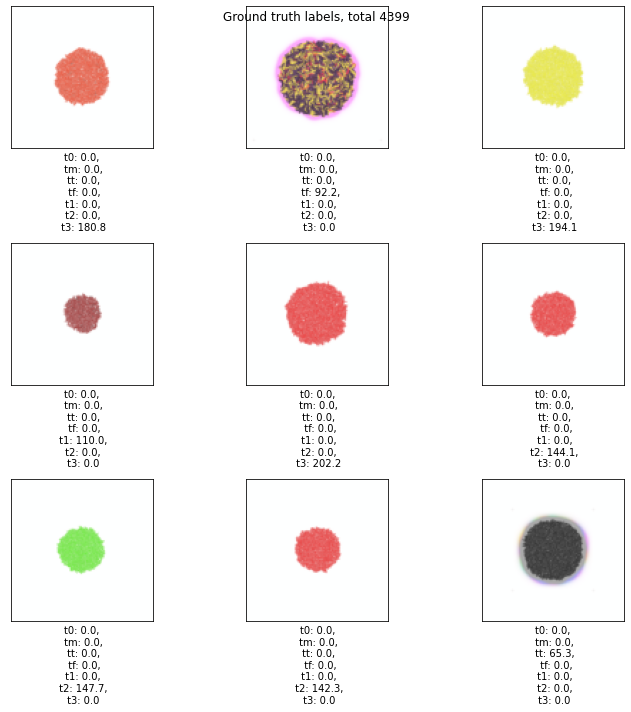

In [23]:
### visualize samples ### 
data = GroDataset(file_path,csv_path,mode="training")
visualize_gt_data(data)

## GroNet

In [24]:
class AnnGro(pl.LightningModule):
  def __init__(self, in_dims=(4,3,100,100), c_i=3, hidden_size=32, fc_1=1000, fc_2=100, num_classes=4,num_types=2, lr=0.33):
    super().__init__()
    # log hyperparameters to W & B
    self.save_hyperparameters()
    
    ### Guillermo architecture Layer ###    
    # convolution #
    self.conv1 = nn.Conv2d(self.hparams["c_i"], self.hparams["hidden_size"], 5,2)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(self.hparams["hidden_size"], self.hparams["hidden_size"]*2, 5,2)
    self.dropout = nn.Dropout()
    
    ### Araya architecture Layer ###    
    # RNN connection #
    self.rnn = nn.RNN(input_size = 25, hidden_size = self.hparams["fc_2"], num_layers = 2, batch_first = True,bidirectional=True)
    self.gru = nn.GRU(input_size = 25, hidden_size = self.hparams["fc_2"], num_layers = 2, batch_first = True)
    self.lstm = nn.LSTM(input_size = 25, hidden_size = self.hparams["fc_2"], num_layers = 2, batch_first = True)
    
    # Fully Connected output #    
    self.fcout = nn.Linear(self.hparams["fc_2"]*2, 7)

    ## accuracy metric ##
    self.train_metric = torchmetrics.MeanSquaredError(compute_on_step=True)
    self.validation_metric = torchmetrics.MeanSquaredError(compute_on_step=True)
    self.test_metric = torchmetrics.MeanSquaredError(compute_on_step=True)

    
 
  def forward(self, x):    
    # input  -> [n, 3, 100, 100]  [batch size, num_channels, width, height]
    x = self.pool(F.relu(self.conv1(x)))  #-> output: n, 32, 93, 93 
    x = self.pool(F.relu(self.conv2(x)))  #-> output: n, 64, 5, 5
    x = self.dropout(x)                   # dropout

    x = x.view(-1, 64 , 5 * 5)            #-> flatten: n, 64, 25 (batch, seq_lenght, features)        
    
    ''' remplace rnn with gru, rnn or lstm '''
    out, _ = self.rnn(x) # n,4,1
    #out, _ = self.gru(x) # n,4,1
    #out, _ = self.lstm(x) # n,4,1
    out = out[:,-1,:] 
    out = self.fcout(out)      
    return F.relu(out)
   
  
  ### Get the loss on a batch ###
  def get_loss(self, input_data, ground_truth):
      logits = self(input_data) 
      loss = torchmetrics.functional.mean_squared_log_error(logits, ground_truth)
           
      return logits, loss

  def training_step(self, batch, batch_idx):
    xs, ys = batch        
    logits, loss = self.get_loss(xs, ys)    
        
        
    # logging metrics we calculated by hand
    self.log('train/loss', loss, on_epoch=True)
    accuracy = self.train_metric(logits,ys)
    
    self.log('train/accuracy', accuracy, on_epoch=True)                    
    return loss

  def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.hparams["lr"])

  def test_step(self, batch, batch_idx):
      
    xs,ys = batch
    logits, loss = self.get_loss(xs, ys)
    accuracy = self.test_metric(logits, ys)       
    
    # logging metrics we calculated by hand
    self.log('test/loss', loss, on_epoch=True)    
    self.log('test/accuracy', accuracy, on_epoch=True)  
    return logits   
    
  
  def validation_step(self, batch, batch_idx):
    xs, ys = batch    
    logits, loss = self.get_loss(xs, ys)    
    accuracy = self.validation_metric(logits,ys)
    self.log('validation/accuracy', accuracy, on_epoch=True) 
    
    # logging metrics we calculated by hand
    self.log('validation/loss', loss, on_epoch=True)   
    
    return logits 

In [25]:
class Prediction(pl.Callback):
  def __init__(self, samples, num_samples=30):
    super().__init__()
    self.val_images, self.val_labels = samples
    self.val_images = self.val_images[:num_samples]
    self.val_labels = self.val_labels[:num_samples]       
  
  def on_test_epoch_end(self, trainer, pl_module):
    columns = ['image', 't0', 'tm', 'tt', 'tf', 't1', 't2', 't3']    
    val_images = self.val_images.to(device=pl_module.device)     
    preds = pl_module(val_images)
    
    data = [[wandb.Image(x_i), f"{y_i[0]} - {y_pred[0]}",f"{y_i[1]} - {y_pred[1]}",f"{y_i[2]} - {y_pred[2]}",f"{y_i[3]} - {y_pred[3]}"
    ,f"{y_i[4]} - {y_pred[4]}",f"{y_i[5]} - {y_pred[5]}",f"{y_i[6]} - {y_pred[6]}"] for x_i, y_i, y_pred in list(zip(val_images, self.val_labels, preds))]

    trainer.logger.log_table(key="Inference pred/gt", columns=columns, data=data)

In [26]:
### initialize the dataset with pytorch Lightning ###
dataGro = lightData(file_path=file_path,csv_path=csv_path)
dataGro.setup()
samples = next(iter(dataGro.val_dataloader()))

In [27]:
wandb_logger = WandbLogger(project='demostration_arc_3', job_type='train') #create a logger

In [28]:
from pytorch_lightning import callbacks
trainer = pl.Trainer(
    logger=wandb_logger,    # W&B integration
    log_every_n_steps=50,   # set the logging frequency
    gpus=-1,                # use all GPUs
    max_epochs=12,           # number of epochs    
    precision=16,          # 16 bit precision
    callbacks=[Prediction(samples)]
    )

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [29]:
model = AnnGro()

# train the model #
trainer.fit(model,dataGro)

# evaluate the model on a test set
trainer.test(datamodule=dataGro,
             ckpt_path=None)  # uses last-saved model

wandb.finish()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory ./demostration_arc_3/version_None/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name              | Type             | Params
--------------------------------------------------------
0  | conv1             | Conv2d           | 2.4 K 
1  | pool              | MaxPool2d        | 0     
2  | conv2             | Conv2d           | 51.3 K
3  | dropout           | Dropout          | 0     
4  | rnn               | RNN              | 85.8 K
5  | gru               | GRU              | 98.7 K
6  | lstm              | LSTM             | 131 K 
7  | fcout             | Linear           | 1.4 K 
8  | train_metric      | MeanSquaredError | 0     
9  | validation_metric | Mea

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=12` reached.
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:124: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./demostration_arc_3/version_None/checkpoints/epoch=11-step=828-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at ./demostration_arc_3/version_None/checkpoints/epoch=11-step=828-v1.ckpt


Testing: 0it [00:00, ?it/s]

ValueError: ignored